In [1]:
import os 
os.getcwd()

'/content'

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab Notebooks/debiasing-racial-effect-in-medical-images/CheXpert-baseline"
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/debiasing-racial-effect-in-medical-images/CheXpert-baseline")
# !pip install -r "/content/drive/MyDrive/Colab Notebooks/debiasing-racial-effect-in-medical-images/requirements.txt"
!pip install torchmetrics

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/debiasing-racial-effect-in-medical-images/CheXpert-baseline
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 14.2 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import time
from itertools import islice
from dataclasses import dataclass

# pd.set_option('display.max_columns', 500)
# pd.set_option('display.max_rows', 500)
# import warnings
# warnings.filterwarnings('ignore')
# C:/Users/sshar/AppData/Roaming/jupyter/nbextensions/snippets /snippets.json (jupyter --data-dir)

In [ ]:
from dataset import CheXpertDataset
import utils
from utils import to_gpu

In [ ]:
@dataclass
class TrainingConfigs:
    BATCH_SIZE = 4
    EPOCHS = 3
    LEARNING_RATE = 0.0001
    CHECKPOINT_TIME_INTERVAL = 8 # seconds
    CHECKPOINT_DIR = r"model_checkpoints"
    MODEL_VERSION = "densenet121"
    TRAINED_MODEL_PATH = None

In [ ]:
utils.set_seed()

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((320,320)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
valid_transform = transforms.Compose([
    transforms.Resize((320,320)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
# Create data loaders.
train_dataset = CheXpertDataset(mode='train', data_dir="../data/CheXpert", transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=TrainingConfigs.BATCH_SIZE, shuffle=True)
len(train_dataset)

223414

In [ ]:
valid_dataset = CheXpertDataset(mode='valid', data_dir="../data/CheXpert", transform=valid_transform)
valid_dataset.labels = valid_dataset.labels[:12] # hack for speed debugging
valid_dataloader = DataLoader(valid_dataset, batch_size=TrainingConfigs.BATCH_SIZE, shuffle=False)
len(valid_dataset)

12

In [ ]:
torch.hub._validate_not_a_forked_repo = lambda a,b,c: True # workaround for torch.hub
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
model.classifier = nn.Linear(in_features=1024, out_features=utils.Configs.NUM_CLASSES, bias=True) # updating model output dim

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=TrainingConfigs.LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [ ]:
model, results, last_epoch, last_iter = utils.get_previos_training_place(model, TrainingConfigs)
last_epoch, last_iter

(0, -1)

In [ ]:
# ls "../data/CheXpert/CheXpert-v1.0-small/train/patient32454"
import os
_, subdirs, _ = next(os.walk("../data/CheXpert/CheXpert-v1.0-small/train"))


KeyboardInterrupt: ignored

In [ ]:
# subdirs_fullpath = [os.path.join("../data/CheXpert/CheXpert-v1.0-small/train", d) for d in subdirs]
# len(subdirs)
train_dataset.labels.Path[0][:60]
# subdirs_fullpath[0]

'../data/CheXpert/CheXpert-v1.0-small/train/patient00001/stud'

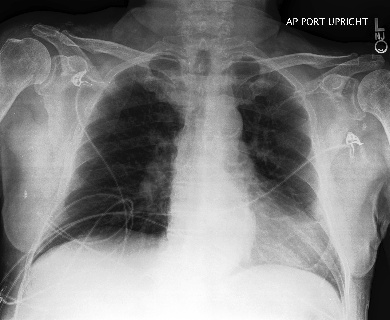

In [ ]:
from PIL import Image
image = Image.open("../data/CheXpert/CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg")
# valid_dataset.labels.Path[0]
image

In [ ]:
model.train()
model = to_gpu(model)
start_time = time.time()
print("Model loaded to GPU")
for epoch in range(last_epoch, TrainingConfigs.EPOCHS):
  train_dataloader_iter = islice(tqdm(enumerate(train_dataloader), total=len(train_dataloader)), 
                                  last_iter+1, len(train_dataloader)) # fast foward dataloader
  print("Finished data loader fast foward.")
  for i, (images, labels) in train_dataloader_iter:
      print(i)
      images = to_gpu(images)
      labels = to_gpu(labels)        
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      results['train_loss'].append(loss.item())
      if time.time()-start_time > TrainingConfigs.CHECKPOINT_TIME_INTERVAL:
          utils.create_checkpoint(model, epoch, i, valid_dataloader, criterion, results, TrainingConfigs)
          print('Epoch [%d/%d],   Iter [%d/%d],   Train Loss: %.4f,   Valid Loss: %.4f,   Valid AUC: %.4f' 
                  %(epoch+1, TrainingConfigs.EPOCHS,
                    i, len(train_dataloader)-1, 
                    np.mean(results["train_loss"][-100:]),
                    results["valid_loss"][-1],
                    results["valid_auc"][-1]),
                end="\n\n")
          start_time = time.time()

Model loaded to GPU


  0%|          | 0/55854 [00:00<?, ?it/s]

Finished data loader fast foward.


FileNotFoundError: ignored